<img src='https://radiant-assets.s3-us-west-2.amazonaws.com/PrimaryRadiantMLHubLogo.png' alt='Radiant MLHub Logo' width='300'/>

# CV4A ICRL Crop Type Classification Challenge
# A Guide to load the data in Python

In [36]:
# Required libraries
import tifffile as tiff
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
def load_file(fp):
    """Takes a PosixPath object or string filepath
    and returns np array"""
    
    return tiff.imread(fp.__str__())

In [16]:
# List of dates that an observation from Sentinel-2 is provided in the training dataset
dates = [datetime.datetime(2019, 6, 6, 8, 10, 7),
         datetime.datetime(2019, 7, 1, 8, 10, 4),
         datetime.datetime(2019, 7, 6, 8, 10, 8),
         datetime.datetime(2019, 7, 11, 8, 10, 4),
         datetime.datetime(2019, 7, 21, 8, 10, 4),
         datetime.datetime(2019, 8, 5, 8, 10, 7),
         datetime.datetime(2019, 8, 15, 8, 10, 6),
         datetime.datetime(2019, 8, 25, 8, 10, 4),
         datetime.datetime(2019, 9, 9, 8, 9, 58),
         datetime.datetime(2019, 9, 19, 8, 9, 59),
         datetime.datetime(2019, 9, 24, 8, 9, 59),
         datetime.datetime(2019, 10, 4, 8, 10),
         datetime.datetime(2019, 11, 3, 8, 10)]

In [17]:
# List of Sentinel-2 bands in the dataset
bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'CLD']

In [38]:
# Sample file to load:
file_name = "../data/00/20190825/0_B03_20190825.tif"
band_data = load_file(file_name)

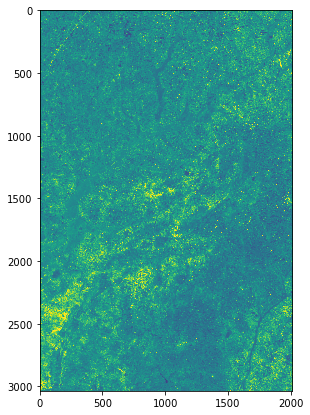

In [39]:
fig = plt.figure(figsize=(7, 7))
plt.imshow(band_data, vmin=0, vmax=0.15)